# Handwriten Recognition System
---

The [MNIST dataset](http://yann.lecun.com/exdb/mnist/), a collection of handwritten digit images, has been widely used as a benchmark for image classification tasks in the field of machine learning. 
In this notebook, we will explore the process of training a Multi-Layer Perceptron (MLP), a type of neural network, to classify the images contained in the MNIST database.

We will break down the process into four key steps:

The process will be broken down into the following steps:
1. Load and visualize the data to get a better understanding of the distribution and characteristics of the images.
2. Define a neural network architecture that can accurately classify the images.
3. Train the model by updating its parameters based on the training data.
4. Evaluate the performance of the trained model on a separate test dataset to measure its accuracy and identify any areas for improvement.

Before we start, we will import the necessary libraries for working with data and PyTorch, as well as a few additional libraries for convenience. With these tools in hand, we are ready to dive into the exciting task of building and training our very own MNIST classifier!

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import multiprocessing

---
## Load the Dataset

In this section, we will load the `MNIST dataset` and specify the transforms we want to apply to it. 

Once we have created the dataset, we will define a DataLoader for both the train and the test set. 
By using a DataLoader, we can shuffle the data, set the batch size, and apply any other necessary transformations in an organized and efficient manner."

In [3]:
# number of subprocesses to use for data loading
# We set this equal to the number of CPUs available
# in this machine
num_workers = multiprocessing.cpu_count()

def create_datasets(batch_size): 
   
    # Define the data transformations that will be applied to the images
    transform = transforms.Compose([
        # This transforms takes a np.array or a PIL image of integers
        # in the range 0-255 and transforms it to a float tensor in the
        # range 0.0 - 1.0
        transforms.ToTensor(),
        # This then renormalize the tensor to be between -1.0 and 1.0,
        # which is a better range for modern activation functions like
        # Relu 
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    
    # Load the MNIST train and validation dataset
    trainval_data = torchvision.datasets.MNIST(
        root="data", train=True, download=True, transform=transform
    )

    # Split in train and validation
    train_len = int(len(trainval_data) * 0.8)
    val_len = len(trainval_data) - train_len
    train_subset, val_subset = torch.utils.data.random_split(
        trainval_data, [train_len, val_len], generator=torch.Generator().manual_seed(42)
    )

    train_loader = torch.utils.data.DataLoader( dataset=train_subset, shuffle=True, batch_size=batch_size, num_workers=num_workers)
    val_loader = torch.utils.data.DataLoader(dataset=val_subset, batch_size=batch_size, num_workers=num_workers)
    print(f"Using {train_len} examples for training and {val_len} for validation")
    
    # Load the MNIST test dataset
    test_subset = torchvision.datasets.MNIST(root="data", train=False, download=True, transform=transform)
    
    test_loader = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, num_workers=num_workers)
    print(f"Using {len(test_subset)} for testing")

    return train_loader, val_loader, test_loader

# Set the batch size for the dataloaders
batch_size = 250

# Create the train and test dataloaders
train_loader, val_loader, test_loader = create_datasets(batch_size)



Using 48000 examples for training and 12000 for validation
Using 10000 for testing


/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Explore the Dataset

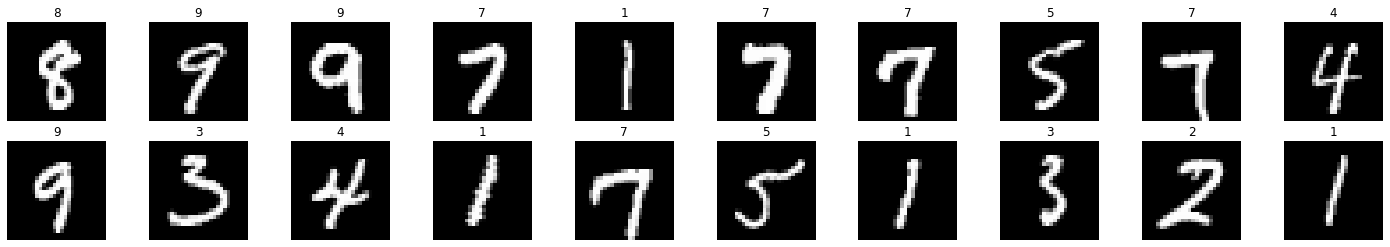

In [4]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig, subs = plt.subplots(2, 10, figsize=(25, 4))
for idx, sub in zip(np.arange(20), subs.flatten()):
    sub.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    sub.set_title(str(labels[idx].item()))
    sub.axis("off")

### Image in More Detail

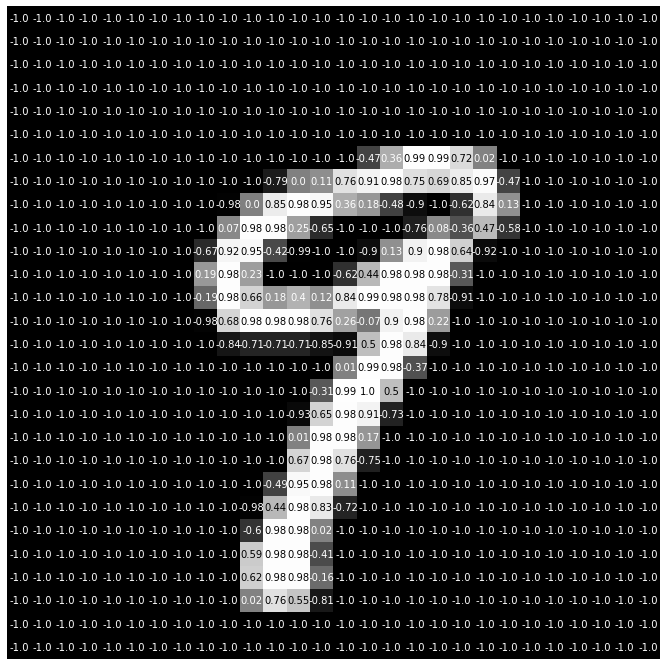

In [5]:
img = np.squeeze(images[1])

fig, sub = plt.subplots(figsize = (12,12)) 
sub.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        sub.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')
        sub.axis("off")

---
## Network Architecture

The architecture will be responsible for seeing as input a 784-dim Tensor of pixel values for each image, and producing a Tensor of length 10 (our number of classes) that indicates the class scores for an input image. 

*Note*: If we did not flatten the tensors in transforms or as part of the preprocessing and we are using only `Linear` layers, we have to make sure to use the `Flatten` layer in our network!

In [7]:
class Net(nn.Module):
    def __init__(self):
        # Initialize the neural network architecture
        super().__init__()
        
        # Set the activation function to ReLU
        self.activation = F.relu
        
        # Create the first fully connected layer, 
        # which takes a 28x28 image as input and outputs 128 features
        self.fc1 = nn.Linear(28 * 28, 128)
        
        # Create the second fully connected layer, 
        # which takes the 128 features from the previous layer and outputs 84 features
        self.fc2 = nn.Linear(128, 84)
        
        # Create the final fully connected layer, 
        # which takes the 84 features from the previous layer and outputs 10 features (one for each class)
        self.fc3 = nn.Linear(84, 10)
        
        # Set up dropout with a probability of 0.5
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Flatten the input tensor to a 1D tensor
        x = torch.flatten(x, 1)
        
        # Apply the first fully connected layer followed by the activation function
        x = self.activation(self.fc1(x))
        
        # Apply dropout regularization to the output of the first fully connected layer
        x = self.dropout(x)
        
        # Apply the second fully connected layer followed by the activation function
        x = self.activation(self.fc2(x))
        
        # Apply dropout regularization to the output of the second fully connected layer
        x = self.dropout(x)
        
        # Apply the final fully connected layer 
        # (without an activation function) to get the network's raw output
        x = self.fc3(x)
        
        # Return the raw output
        return x

# initialize the NN
model = Net()
print(model)

Net(
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### Loss Function and Optimizer

It's recommended that you use [Cross-Entropy Loss for Classification](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). If you look at the documentation (linked above), you can see that PyTorch's cross entropy function applies a softmax function to the output layer *and* then calculates the log loss. That's the mainly reason why we dont apply any activation function on the last layer of the network architecture.

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

---
## Train the Network

To train a model with a batch of data, do the following for each batch:

1. Clear the gradients of all optimized variables
2. Pass the inputs through the model to get predicted outputs
3. Calculate the loss between the predicted outputs and the true labels
4. Compute the gradients of the loss with respect to the model parameters
5. Update the model parameters using an optimizer (e.g. stochastic gradient descent)
6. Keep track of the average training loss

The model should be trained for multiple epochs (e.g. 20-50), with the goal of decreasing the training loss over time while avoiding overfitting.

In [12]:
# number of epochs to train the model
n_epochs = 50  # suggest training between 20-50 epochs

model.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for batch_idx, (data, target) in tqdm(
            enumerate(train_loader),
            desc="Training",
            total=len(train_loader),
            leave=True,
            ncols=80,
        ):
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)
    
    # Validate
    with torch.no_grad():

        # set the model to evaluation mode
        model.eval()

        valid_loss = 0.0
        for batch_idx, (data, target) in tqdm(
            enumerate(val_loader),
            desc="Validating",
            total=len(val_loader),
            leave=True,
            ncols=80,
        ):

            # 1. forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)  # =
            # 2. calculate the loss
            loss_value = criterion(output, target)  # =

            # Calculate average validation loss
            valid_loss = valid_loss + (
                (1 / (batch_idx + 1)) * (loss_value.data.item() - valid_loss)
            )
    
    print(f"Epoch {epoch+1}: training loss {train_loss:.5f}, valid loss {valid_loss:.5f}")

Validating: 100%|█████████████████████████████| 188/188 [00:06<00:00, 29.40it/s]

Epoch 1: training loss 0.79882, valid loss 0.33703



Validating: 100%|█████████████████████████████| 188/188 [00:06<00:00, 29.72it/s]

Epoch 2: training loss 0.23042, valid loss 0.20330



Validating: 100%|█████████████████████████████| 188/188 [00:06<00:00, 29.94it/s]

Epoch 3: training loss 0.15776, valid loss 0.15089



Validating: 100%|█████████████████████████████| 188/188 [00:06<00:00, 27.90it/s]

Epoch 4: training loss 0.12405, valid loss 0.13960



Validating: 100%|█████████████████████████████| 188/188 [00:06<00:00, 30.25it/s]

Epoch 5: training loss 0.10255, valid loss 0.13708



Validating: 100%|█████████████████████████████| 188/188 [00:07<00:00, 26.52it/s]

Epoch 6: training loss 0.09022, valid loss 0.11453



Validating: 100%|█████████████████████████████| 188/188 [00:06<00:00, 28.35it/s]

Epoch 7: training loss 0.07712, valid loss 0.10890



Validating: 100%|█████████████████████████████| 188/188 [00:06<00:00, 29.94it/s]


Epoch 8: training loss 0.07121, valid loss 0.12986


Validating: 100%|█████████████████████████████| 188/188 [00:06<00:00, 30.57it/s]

Epoch 9: training loss 0.06478, valid loss 0.11851



Validating: 100%|█████████████████████████████| 188/188 [00:06<00:00, 31.06it/s]

Epoch 10: training loss 0.05855, valid loss 0.10608



Validating: 100%|█████████████████████████████| 188/188 [00:05<00:00, 33.05it/s]

Epoch 11: training loss 0.05353, valid loss 0.11719



Validating: 100%|█████████████████████████████| 188/188 [00:05<00:00, 34.94it/s]

Epoch 12: training loss 0.04581, valid loss 0.12058



Validating: 100%|█████████████████████████████| 188/188 [00:05<00:00, 37.50it/s]

Epoch 13: training loss 0.04643, valid loss 0.11172



Validating: 100%|█████████████████████████████| 188/188 [00:05<00:00, 37.14it/s]

Epoch 14: training loss 0.04333, valid loss 0.14205



Validating: 100%|█████████████████████████████| 188/188 [00:05<00:00, 31.44it/s]

Epoch 15: training loss 0.03837, valid loss 0.10803



Validating: 100%|█████████████████████████████| 188/188 [00:06<00:00, 29.72it/s]

Epoch 16: training loss 0.03625, valid loss 0.13357



Validating: 100%|█████████████████████████████| 188/188 [00:05<00:00, 31.84it/s]

Epoch 17: training loss 0.03555, valid loss 0.14244



Validating: 100%|█████████████████████████████| 188/188 [00:06<00:00, 30.88it/s]

Epoch 18: training loss 0.03346, valid loss 0.13726



Validating: 100%|█████████████████████████████| 188/188 [00:06<00:00, 30.77it/s]

Epoch 19: training loss 0.02891, valid loss 0.12452



Validating: 100%|█████████████████████████████| 188/188 [00:06<00:00, 30.70it/s]

Epoch 20: training loss 0.02935, valid loss 0.13651



Validating: 100%|█████████████████████████████| 188/188 [00:06<00:00, 30.25it/s]

Epoch 21: training loss 0.02524, valid loss 0.12997



Validating: 100%|█████████████████████████████| 188/188 [00:06<00:00, 30.46it/s]

Epoch 22: training loss 0.02724, valid loss 0.14274



Validating: 100%|█████████████████████████████| 188/188 [00:06<00:00, 30.75it/s]

Epoch 23: training loss 0.02622, valid loss 0.14540



Validating: 100%|█████████████████████████████| 188/188 [00:06<00:00, 30.82it/s]

Epoch 24: training loss 0.02665, valid loss 0.13923



Validating: 100%|█████████████████████████████| 188/188 [00:06<00:00, 30.68it/s]

Epoch 25: training loss 0.02312, valid loss 0.13802



Validating: 100%|█████████████████████████████| 188/188 [00:06<00:00, 30.03it/s]

Epoch 26: training loss 0.02426, valid loss 0.14829



Validating: 100%|█████████████████████████████| 188/188 [00:05<00:00, 31.34it/s]

Epoch 27: training loss 0.01745, valid loss 0.16624



Validating: 100%|█████████████████████████████| 188/188 [00:05<00:00, 31.36it/s]

Epoch 28: training loss 0.02015, valid loss 0.16521



Validating: 100%|█████████████████████████████| 188/188 [00:06<00:00, 30.81it/s]

Epoch 29: training loss 0.02239, valid loss 0.14615



Validating: 100%|█████████████████████████████| 188/188 [00:05<00:00, 31.36it/s]

Epoch 30: training loss 0.01778, valid loss 0.15392



Validating: 100%|█████████████████████████████| 188/188 [00:06<00:00, 29.01it/s]

Epoch 31: training loss 0.02046, valid loss 0.15109



Validating: 100%|█████████████████████████████| 188/188 [00:06<00:00, 29.69it/s]

Epoch 32: training loss 0.01615, valid loss 0.15109



Validating: 100%|█████████████████████████████| 188/188 [00:06<00:00, 29.80it/s]

Epoch 33: training loss 0.02304, valid loss 0.17622



Validating: 100%|█████████████████████████████| 188/188 [00:06<00:00, 30.64it/s]

Epoch 34: training loss 0.01294, valid loss 0.17784



Validating: 100%|█████████████████████████████| 188/188 [00:06<00:00, 30.78it/s]

Epoch 35: training loss 0.01603, valid loss 0.18087



Validating: 100%|█████████████████████████████| 188/188 [00:06<00:00, 30.70it/s]

Epoch 36: training loss 0.01657, valid loss 0.20404



Validating: 100%|█████████████████████████████| 188/188 [00:06<00:00, 29.03it/s]

Epoch 37: training loss 0.01568, valid loss 0.16894



Validating: 100%|█████████████████████████████| 188/188 [00:06<00:00, 27.82it/s]

Epoch 38: training loss 0.01493, valid loss 0.22360



Validating: 100%|█████████████████████████████| 188/188 [00:05<00:00, 32.45it/s]

Epoch 39: training loss 0.01189, valid loss 0.16371



Validating: 100%|█████████████████████████████| 188/188 [00:05<00:00, 35.56it/s]

Epoch 40: training loss 0.01740, valid loss 0.17139



Validating: 100%|█████████████████████████████| 188/188 [00:05<00:00, 34.21it/s]

Epoch 41: training loss 0.01619, valid loss 0.16488



Validating: 100%|█████████████████████████████| 188/188 [00:05<00:00, 33.16it/s]

Epoch 42: training loss 0.01323, valid loss 0.17257



Validating: 100%|█████████████████████████████| 188/188 [00:05<00:00, 34.59it/s]

Epoch 43: training loss 0.01314, valid loss 0.16659



Validating: 100%|█████████████████████████████| 188/188 [00:06<00:00, 29.41it/s]

Epoch 44: training loss 0.01492, valid loss 0.17591



Validating: 100%|█████████████████████████████| 188/188 [00:06<00:00, 27.76it/s]

Epoch 45: training loss 0.01710, valid loss 0.18157



Validating: 100%|█████████████████████████████| 188/188 [00:05<00:00, 31.45it/s]

Epoch 46: training loss 0.01310, valid loss 0.19101



Validating: 100%|█████████████████████████████| 188/188 [00:06<00:00, 29.33it/s]

Epoch 47: training loss 0.01464, valid loss 0.18945



Validating: 100%|█████████████████████████████| 188/188 [00:06<00:00, 27.01it/s]

Epoch 48: training loss 0.01387, valid loss 0.20952



Validating: 100%|█████████████████████████████| 188/188 [00:07<00:00, 26.63it/s]

Epoch 49: training loss 0.01233, valid loss 0.20429



Validating: 100%|█████████████████████████████| 188/188 [00:06<00:00, 27.51it/s]

Epoch 50: training loss 0.01320, valid loss 0.19651


---
## Test the Trained Network

After training a model on a batch of data, we can test its performance on previously unseen test data. This is an important step to check if the model is able to generalize well to new data.

To evaluate the model's performance, it can be useful to look at metrics like loss and accuracy, both overall and for each individual class.

Before making predictions on the test data, it's important to set the model to evaluation mode using `model.eval()`. This ensures that certain layers, like dropout layers, are turned off during evaluation to allow every node to be "on" and get a more accurate representation of the model's performance

In [13]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0.0 for i in range(10))
class_total = list(0.0 for i in range(10))

model.eval()  # prep model for *evaluation*

for batch_idx, (data, target) in tqdm(
    enumerate(test_loader),
    desc="Testing",
    total=len(test_loader),
    leave=True,
    ncols=80,
):
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item() * data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(data.shape[0]):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss / len(test_loader.dataset)
print(f"Test Loss: {test_loss:.6f}\n")

for i in range(10):
    if class_total[i] > 0:
        print(
            f"Test Accuracy of {i}: {100 * class_correct[i] / class_total[i]:.2f}%% "
            f"({int(np.sum(class_correct[i]))}/{int(np.sum(class_total[i]))})"
        )
    else:
        print(f"Test Accuracy of {classes[i]}: N/A (no training examples)")

print(
    f"\nTest Accuracy (Overall): {100.0 * np.sum(class_correct) / np.sum(class_total)}%% "
    f"({int(np.sum(class_correct))}/{int(np.sum(class_total))})"
)

Testing: 100%|████████████████████████████████| 157/157 [00:06<00:00, 24.62it/s]

Test Loss: 0.167053

Test Accuracy of 0: 98.78%% (968/980)
Test Accuracy of 1: 99.21%% (1126/1135)
Test Accuracy of 2: 96.71%% (998/1032)
Test Accuracy of 3: 98.42%% (994/1010)
Test Accuracy of 4: 98.88%% (971/982)
Test Accuracy of 5: 95.96%% (856/892)
Test Accuracy of 6: 98.23%% (941/958)
Test Accuracy of 7: 96.40%% (991/1028)
Test Accuracy of 8: 94.87%% (924/974)
Test Accuracy of 9: 96.04%% (969/1009)

Test Accuracy (Overall): 97.38%% (9738/10000)


### Sample Test Results

In order to visualize how well the trained model is performing, we can display the test images and their corresponding labels in the following format: predicted (ground-truth).

To make it easier to distinguish between accurately classified and incorrectly classified examples, the text will be displayed in green for accurate predictions and red for incorrect predictions. This will make it easier to quickly identify any areas where the model may be struggling and may need further improvement.

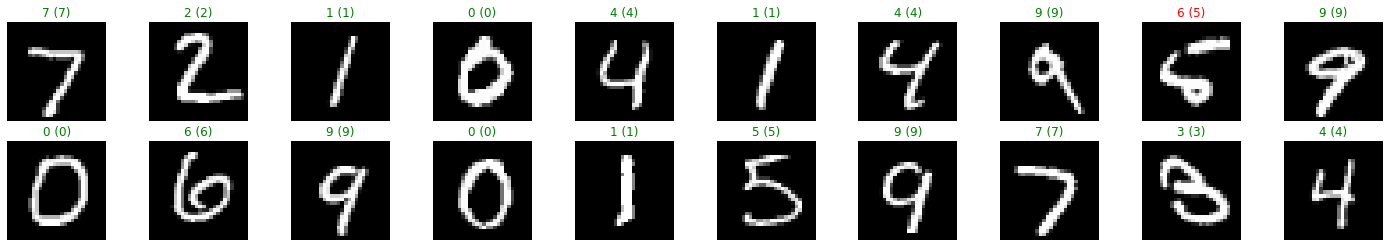

In [14]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig, subs = plt.subplots(2, 10, figsize=(25, 4))
for idx, sub in zip(range(20), subs.flatten()):
    sub.imshow(np.squeeze(images[idx]), cmap='gray')
    sub.set_title(f"{str(preds[idx].item())} ({str(labels[idx].item())})",
                 color=("green" if preds[idx]==labels[idx] else "red"))
    sub.axis("off")